# Aurora Forecasting - Part 03: Training Pipeline

🗒️ This notebook is divided into the following sections:
Initialize Hopsworks connection and retrieve Feature Groups.

Create a Feature View and Training Dataset.

Train a Random Forest model to predict the Kp index from solar wind features.

Evaluate model performance.

Register the model in the Hopsworks Model Registry.

# Import and setup


In [31]:
import pandas as pd
import hopsworks
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib
import os
from config import HopsworksSettings

# Setup settings
settings = HopsworksSettings()

# Login to Hopsworks
project = hopsworks.login(
    project=settings.HOPSWORKS_PROJECT,
    api_key_value=settings.HOPSWORKS_API_KEY.get_secret_value()
)
fs = project.get_feature_store()

HopsworksSettings initialized!
2026-01-05 22:15:20,810 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-05 22:15:20,820 INFO: Initializing external client
2026-01-05 22:15:20,821 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 22:15:21,552 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-05 22:15:22,509 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1299605


# Create the lagged features

In [32]:
# Get the solar wind feature group
solar_wind_fg = fs.get_feature_group(name="solar_wind_fg", version=2)

In [33]:
# Create lagged for the KP index to capture temporal dependencies
merged_df = solar_wind_fg.read()
# Ensure the date column is in datetime format
merged_df['date_and_time'] = pd.to_datetime(merged_df['date_and_time'], errors='coerce')
# Sort by chronological order
merged_df = merged_df.sort_values('date_and_time').reset_index(drop=True)

LAGS = [1, 2, 3, 4]  # 30m, 60m, 90m, 120m

for col in ['by_gsm', 'bz_gsm', 'density', 'speed']:
    for lag in LAGS:
        merged_df[f"{col}_lag_{lag}"] = merged_df[col].shift(lag)

# Drop rows with NaN values created by lagging
merged_df = merged_df.dropna().reset_index(drop=True)

merged_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.40s) 


,date_and_time,by_gsm,bz_gsm,density,speed,kp_index,by_gsm_lag_1,by_gsm_lag_2,by_gsm_lag_3,by_gsm_lag_4,...,bz_gsm_lag_3,bz_gsm_lag_4,density_lag_1,density_lag_2,density_lag_3,density_lag_4,speed_lag_1,speed_lag_2,speed_lag_3,speed_lag_4
0,2024-01-06 20:00:00+00:00,-0.600000,-2.400000,3.600000,337.000000,0.70,-1.300000,-0.700000,-0.300000,-0.100000,...,0.100000,0.300000,3.000000,2.900000,2.900000,2.700000,330.000000,329.000000,329.000000,326.000000
1,2024-01-06 21:00:00+00:00,-1.600000,-2.200000,3.500000,340.000000,1.00,-0.600000,-1.300000,-0.700000,-0.300000,...,0.200000,0.100000,3.600000,3.000000,2.900000,2.900000,337.000000,330.000000,329.000000,329.000000
2,2024-01-06 22:00:00+00:00,-2.000000,-1.400000,3.500000,336.000000,1.00,-1.600000,-0.600000,-1.300000,-0.700000,...,-1.400000,0.200000,3.500000,3.600000,3.000000,2.900000,340.000000,337.000000,330.000000,329.000000
3,2024-01-06 23:00:00+00:00,-2.000000,-1.700000,3.400000,331.000000,1.00,-2.000000,-1.600000,-0.600000,-1.300000,...,-2.400000,-1.400000,3.500000,3.500000,3.600000,3.000000,336.000000,340.000000,337.000000,330.000000
4,2024-01-07 00:00:00+00:00,-2.000000,-1.200000,3.500000,331.000000,0.00,-2.000000,-2.000000,-1.600000,-0.600000,...,-2.200000,-2.400000,3.400000,3.500000,3.500000,3.600000,331.000000,336.000000,340.000000,337.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16607,2026-01-05 05:00:00+00:00,3.397000,-6.455667,4.294000,434.733337,4.00,1.455667,1.165714,0.309333,-2.849333,...,-8.538667,-5.560000,3.826429,4.460000,4.094333,1.682353,448.192871,439.100006,448.306671,467.723541
16608,2026-01-05 06:00:00+00:00,4.555807,-5.634516,4.468709,437.232269,4.33,3.397000,1.455667,1.165714,0.309333,...,-8.553572,-8.538667,4.294000,3.826429,4.460000,4.094333,434.733337,448.192871,439.100006,448.306671
16609,2026-01-05 07:00:00+00:00,4.168125,-5.858125,3.764286,433.885712,4.33,4.555807,3.397000,1.455667,1.165714,...,-9.187000,-8.553572,4.468709,4.294000,3.826429,4.460000,437.232269,434.733337,448.192871,439.100006
16610,2026-01-05 08:00:00+00:00,-6.624737,-4.362632,2.836216,419.481079,4.33,4.168125,4.555807,3.397000,1.455667,...,-6.455667,-9.187000,3.764286,4.468709,4.294000,3.826429,433.885712,437.232269,434.733337,448.192871


In [34]:
# Add rolling statistics features
WINDOWS = [2, 4]  # 1h, 2h

for col in ['bz_gsm', 'speed', 'density']:
    for w in WINDOWS:
        merged_df[f"{col}_roll_mean_{w}"] = merged_df[col].rolling(w).mean()
        merged_df[f"{col}_roll_std_{w}"] = merged_df[col].rolling(w).std()

# Drop rows with NaN values created by rolling statistics
merged_df = merged_df.dropna().reset_index(drop=True)
merged_df

,date_and_time,by_gsm,bz_gsm,density,speed,kp_index,by_gsm_lag_1,by_gsm_lag_2,by_gsm_lag_3,by_gsm_lag_4,...,bz_gsm_roll_mean_4,bz_gsm_roll_std_4,speed_roll_mean_2,speed_roll_std_2,speed_roll_mean_4,speed_roll_std_4,density_roll_mean_2,density_roll_std_2,density_roll_mean_4,density_roll_std_4
0,2024-01-06 23:00:00+00:00,-2.000000,-1.700000,3.400000,331.000000,1.00,-2.000000,-1.600000,-0.600000,-1.300000,...,-1.925000,0.457347,333.500000,3.535534,336.000000,3.741657,3.450000,0.070711,3.500000,0.081650
1,2024-01-07 00:00:00+00:00,-2.000000,-1.200000,3.500000,331.000000,0.00,-2.000000,-2.000000,-1.600000,-0.600000,...,-1.625000,0.434933,331.000000,0.000000,334.500000,4.358899,3.450000,0.070711,3.475000,0.050000
2,2024-01-07 01:00:00+00:00,-2.400000,-0.700000,3.400000,328.000000,0.00,-2.000000,-2.000000,-2.000000,-1.600000,...,-1.250000,0.420317,329.500000,2.121320,331.500000,3.316625,3.450000,0.070711,3.450000,0.057735
3,2024-01-07 02:00:00+00:00,-2.000000,-0.600000,3.300000,323.000000,0.00,-2.400000,-2.000000,-2.000000,-2.000000,...,-1.050000,0.506623,325.500000,3.535534,328.250000,3.774917,3.350000,0.070711,3.400000,0.081650
4,2024-01-07 03:00:00+00:00,-2.400000,0.300000,3.000000,320.000000,0.00,-2.000000,-2.400000,-2.000000,-2.000000,...,-0.550000,0.624500,321.500000,2.121320,325.500000,4.932883,3.150000,0.212132,3.300000,0.216025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16604,2026-01-05 05:00:00+00:00,3.397000,-6.455667,4.294000,434.733337,4.00,1.455667,1.165714,0.309333,-2.849333,...,-8.183726,1.191010,441.463104,9.517328,442.583221,6.781827,4.060214,0.330623,4.168691,0.272786
16605,2026-01-05 06:00:00+00:00,4.555807,-5.634516,4.468709,437.232269,4.33,3.397000,1.455667,1.165714,0.309333,...,-7.457689,1.685179,435.982803,1.767012,439.814621,5.864973,4.381355,0.123538,4.262285,0.301485
16606,2026-01-05 07:00:00+00:00,4.168125,-5.858125,3.764286,433.885712,4.33,4.555807,3.397000,1.455667,1.165714,...,-6.783827,1.639184,435.558990,2.366374,438.511047,6.609029,4.116498,0.498103,4.088356,0.346692
16607,2026-01-05 08:00:00+00:00,-6.624737,-4.362632,2.836216,419.481079,4.33,4.168125,4.555807,3.397000,1.455667,...,-5.577735,0.881113,426.683395,10.185613,431.333099,8.028035,3.300251,0.656244,3.840803,0.733645


In [35]:
# Dynamic pressure 
# Pdyn ~ n * v^2 (unità non critiche per RF)
merged_df['dynamic_pressure'] = merged_df['density'] * (merged_df['speed'] ** 2)

merged_df

,date_and_time,by_gsm,bz_gsm,density,speed,kp_index,by_gsm_lag_1,by_gsm_lag_2,by_gsm_lag_3,by_gsm_lag_4,...,bz_gsm_roll_std_4,speed_roll_mean_2,speed_roll_std_2,speed_roll_mean_4,speed_roll_std_4,density_roll_mean_2,density_roll_std_2,density_roll_mean_4,density_roll_std_4,dynamic_pressure
0,2024-01-06 23:00:00+00:00,-2.000000,-1.700000,3.400000,331.000000,1.00,-2.000000,-1.600000,-0.600000,-1.300000,...,0.457347,333.500000,3.535534,336.000000,3.741657,3.450000,0.070711,3.500000,0.081650,372507.40625
1,2024-01-07 00:00:00+00:00,-2.000000,-1.200000,3.500000,331.000000,0.00,-2.000000,-2.000000,-1.600000,-0.600000,...,0.434933,331.000000,0.000000,334.500000,4.358899,3.450000,0.070711,3.475000,0.050000,383463.50000
2,2024-01-07 01:00:00+00:00,-2.400000,-0.700000,3.400000,328.000000,0.00,-2.000000,-2.000000,-2.000000,-1.600000,...,0.420317,329.500000,2.121320,331.500000,3.316625,3.450000,0.070711,3.450000,0.057735,365785.62500
3,2024-01-07 02:00:00+00:00,-2.000000,-0.600000,3.300000,323.000000,0.00,-2.400000,-2.000000,-2.000000,-2.000000,...,0.506623,325.500000,3.535534,328.250000,3.774917,3.350000,0.070711,3.400000,0.081650,344285.68750
4,2024-01-07 03:00:00+00:00,-2.400000,0.300000,3.000000,320.000000,0.00,-2.000000,-2.400000,-2.000000,-2.000000,...,0.624500,321.500000,2.121320,325.500000,4.932883,3.150000,0.212132,3.300000,0.216025,307200.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16604,2026-01-05 05:00:00+00:00,3.397000,-6.455667,4.294000,434.733337,4.00,1.455667,1.165714,0.309333,-2.849333,...,1.191010,441.463104,9.517328,442.583221,6.781827,4.060214,0.330623,4.168691,0.272786,811536.31250
16605,2026-01-05 06:00:00+00:00,4.555807,-5.634516,4.468709,437.232269,4.33,3.397000,1.455667,1.165714,0.309333,...,1.685179,435.982803,1.767012,439.814621,5.864973,4.381355,0.123538,4.262285,0.301485,854292.37500
16606,2026-01-05 07:00:00+00:00,4.168125,-5.858125,3.764286,433.885712,4.33,4.555807,3.397000,1.455667,1.165714,...,1.639184,435.558990,2.366374,438.511047,6.609029,4.116498,0.498103,4.088356,0.346692,708652.43750
16607,2026-01-05 08:00:00+00:00,-6.624737,-4.362632,2.836216,419.481079,4.33,4.168125,4.555807,3.397000,1.455667,...,0.881113,426.683395,10.185613,431.333099,8.028035,3.300251,0.656244,3.840803,0.733645,499073.00000


In [36]:
# Drop the non-lagged features, because they are non relevant for the prediction
#merged_df = merged_df.drop(columns=['by_gsm', 'bz_gsm', 'density', 'speed'])

In [37]:
# # Recreate train-test split after feature engineering
# split_index = int(0.8 * len(merged_df))
# train_df = merged_df.iloc[:split_index]
# test_df = merged_df.iloc[split_index:]

# # Drop kp_index from train and test. Add it to y_train and y_test
# y_train = train_df['kp_index']
# y_test = test_df['kp_index']
# X_train = train_df.drop(columns=['date_and_time', 'kp_index'])
# X_test = test_df.drop(columns=['date_and_time', 'kp_index'])

# X_train

# Create the new feature group

In [38]:
aurora_fg = fs.get_or_create_feature_group(
    name="aurora_solarwind_features",
    version=5,
    description="Solar wind features with lag and rolling statistics for Kp prediction",
    primary_key=["date_and_time"],
    event_time="date_and_time",
)

aurora_fg.insert(merged_df)

print("Aurora feature group inserted successfully.")


Uploading Dataframe: 100.00% |██████████| Rows 16609/16609 | Elapsed Time: 00:18 | Remaining Time: 00:00


Launching job: aurora_solarwind_features_5_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1299605/jobs/named/aurora_solarwind_features_5_offline_fg_materialization/executions
Aurora feature group inserted successfully.


# Create feature view


In [39]:
# # Remove date_and_time and kp_index before creating the feature view 
# feature_columns = [
#     col for col in merged_df.columns
#     if col not in ['kp_index', 'date_and_time']
# ]

In [40]:
# Get the solar wind feature group
aurora_fg = fs.get_feature_group(name="aurora_solarwind_features", version=5)

# Select features and the label
query = aurora_fg.select_all()

# Create or retrieve the Feature View
# Note: Weather data is used for visibility logic in inference,
# while Kp is predicted solely from solar wind data.
aurora_fv = fs.get_or_create_feature_view(
    name="aurora_kp_view",
    version=5,
    description="Predicting the Kp index from solar wind parameters",
    labels=["kp_index"],
    query=query
)

print("Feature View created/retrieved successfully.")

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1299605/fs/1287235/fv/aurora_kp_view/version/5
Feature View created/retrieved successfully.


# Step 3: Train the Model

Based on your project description, we are implementing a Random Forest Regressor. This model is well-suited for mapping the complex, non-linear relationships between solar wind plasma parameters and geomagnetic activity.

In [41]:
# Get training and test data from the feature view
test_start = pd.to_datetime("2025-08-01").tz_localize("UTC")

X_train, X_test, y_train, y_test = aurora_fv.train_test_split(
    test_start=test_start,
    description="Temporal split for Kp nowcasting"
)

# Remove date_and_time and kp_index from X_train and X_test
X_train = X_train.drop(columns=['date_and_time'])
X_test = X_test.drop(columns=['date_and_time'])

print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_test: {len(X_test)}")
ratio = len(X_train) / (len(X_train) + len(X_test))
print(f"Train ratio: {ratio:.2%}")

# Quick check
assert 'kp_index' not in X_train.columns
assert 'date_and_time' not in X_train.columns


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.66s) 
2026-01-05 22:16:31,014 WARNING: VersionWarning: Incremented version to `1`.

Length of X_train: 13471
Length of X_test: 3138
Train ratio: 81.11%


In [42]:
print("Training XGBoost Regressor...")

# Initialize and train the model
# You can tune hyperparameters like n_estimators and max_depth
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

Training XGBoost Regressor...


In [43]:
# 90% of the points are between 0 and 5. I will introduce a new weighting scheme to give more importance to higher Kp values.
# An error on kp=6 is more critical than an error on kp=2 for aurora visibility.
y_train_np = y_train.values.squeeze()

sample_weights = np.ones_like(y_train_np, dtype=float)
sample_weights[y_train_np >= 5.0] = 3.0
sample_weights[y_train_np >= 6.0] = 5.0


In [44]:
xgb_model.fit(
    X_train,
    y_train.values.ravel(),
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print("XGBoost training completed.")

print("Model training complete.")

XGBoost training completed.
Model training complete.


# Step 4: Model Evaluation

We evaluate the model using Mean Squared Error (MSE) and R-squared to determine how accurately it predicts the geomagnetic Kp index.

In [45]:
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics = {
    "mse": float(mse),
    "rmse": float(rmse),
    "mae": float(mae),
    "r2": float(r2)
}

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

2026-01-05 22:16:33,606 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 22:16:33,608 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 22:16:33,609 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 22:16:33,614 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 22:16:33,615 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 22:16:33,616 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spar

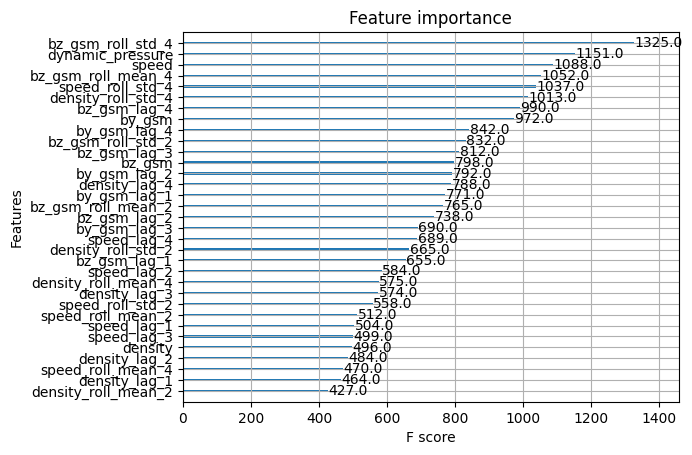

In [46]:
# Plotting feature importances using the plot_importance function from XGBoost
# Creating a directory for the model artifacts if it doesn't exist
images_dir = "./images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

plot_importance(xgb_model)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

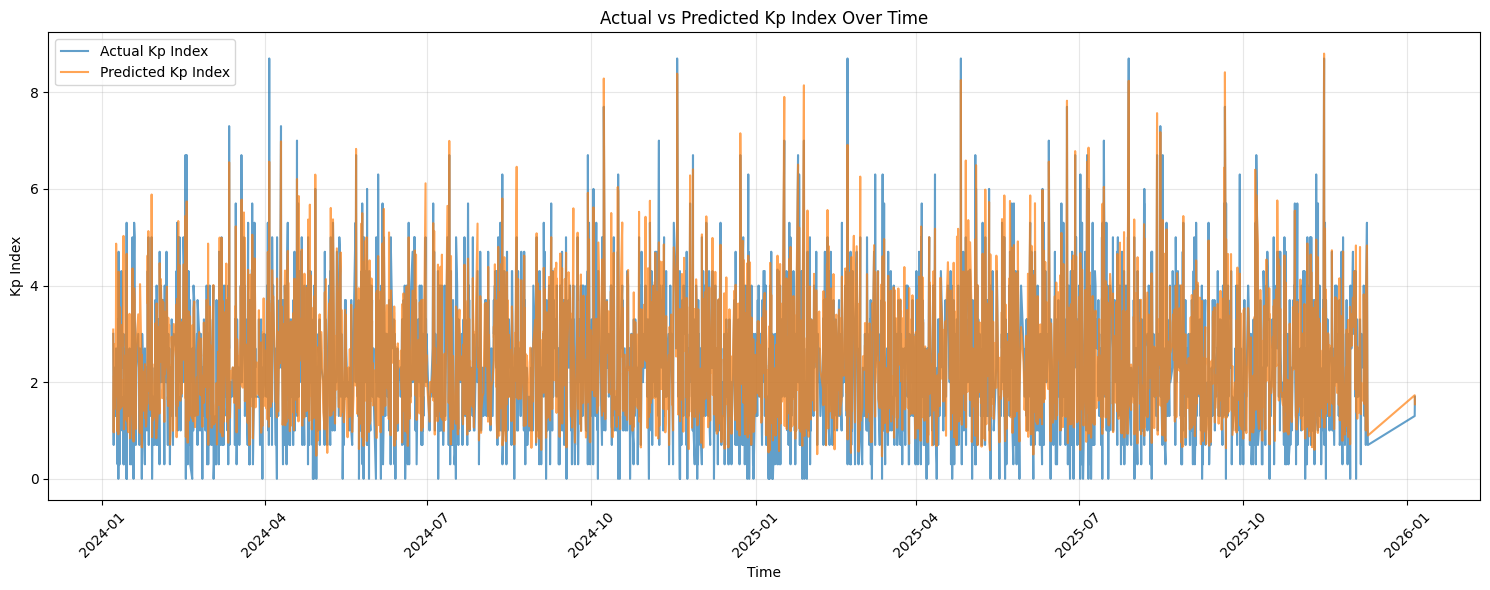

Plot saved to ./images/actual_vs_predicted.png


In [47]:
# Create a comparison plot of actual vs predicted Kp index over time
plt.figure(figsize=(15, 6))

# Get the test dates from merged_df
test_dates = merged_df.loc[X_test.index, 'date_and_time']

plt.plot(test_dates, y_test.values, label='Actual Kp Index', alpha=0.7, linewidth=1.5)
plt.plot(test_dates, y_pred, label='Predicted Kp Index', alpha=0.7, linewidth=1.5)

plt.xlabel('Time')
plt.ylabel('Kp Index')
plt.title('Actual vs Predicted Kp Index Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
prediction_plot_path = images_dir + "/actual_vs_predicted.png"
plt.savefig(prediction_plot_path)
plt.show()

print(f"Plot saved to {prediction_plot_path}")

# Step 5: Register Model to Hopsworks

Once satisfied with the performance, we save the model artifacts and register them in the Hopsworks Model Registry so they can be retrieved by the Batch Inference pipeline.

In [48]:
# Create a local directory for model artifacts
model_dir = "aurora_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model artifact
model_path = os.path.join(model_dir, "model.pkl")
joblib.dump(xgb_model, model_path)

# Get the Model Registry
mr = project.get_model_registry()

# Create the model entry
aurora_model = mr.python.create_model(
    name=settings.MODEL_NAME, # "aurora_kp_rf_model" from config.py
    metrics=metrics,
    description="Random Forest Regressor for predicting Kp index based on solar wind features.",
    #input_example=X_train.sample(1),
    feature_view=aurora_fv
)

# Upload the model to the registry
aurora_model.save(model_dir)

print(f"Model '{settings.MODEL_NAME}' version {aurora_model.version} registered successfully.")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/nico/Documents/GitHub/ID2223_Project/aurora_model/model.pkl: 0.000%|          | 0/2100779 ela…

Uploading /Users/nico/Documents/GitHub/ID2223_Project/model_schema.json: 0.000%|          | 0/2727 elapsed<00:…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1299605/models/aurora_kp_rf_model/7
Model 'aurora_kp_rf_model' version 7 registered successfully.
